In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import requests
from datetime import datetime, timedelta
import time
import pandas as pd
import math

In [2]:
import cvxpy as cp

In [3]:
# updated for solving MPC with TES task to use TES all the time

def chargetime(time): # charge = 1, discharge = -1
    xp = [0, 7.999, 8, 25]
    fp = [1,1,0,0]
    f = interpolate.interp1d(xp, fp, "linear")
    return f(time)

def dischargetime(time): # charge = 1, discharge = -1
    xp = [0, 8.999, 9, 17.999, 18, 25]
    fp = [0,0,-1,-1,0,0]
    f = interpolate.interp1d(xp, fp, "linear")
    return f(time)

# def chargetime(time): # charge = 1, discharge = -1
#     xp = [0, 7.999, 8, 25]
#     fp = [1,1,0,0]
#     f = interpolate.interp1d(xp, fp, "linear")
#     return f(time)

# def dischargetime(time): # charge = 1, discharge = -1
#     xp = [0, 13.999, 14, 17.999, 18, 25]
#     fp = [0,0,-1,-1,0,0]
#     f = interpolate.interp1d(xp, fp, "linear")
#     return f(time)

In [4]:
# PRICES FOR ELECTRICITY
def price(time, type_price='individual_3'):
    if type_price == 'individual_2': 
        # индивидуальный тариф 2ставочный
        xp = [0, 7.999, 8 , 23.999, 24, 25]
        fp = [2.29, 2.29, 6.18, 6.18, 2.29, 2.29]
        f = interpolate.interp1d(xp, fp, "linear")
        return f(time)
    if type_price == 'individual_3': 
        # индивидуальный тариф 3ставочный
        xp = [0, 7.999, 8 , 10.999, 11, 17.999, 18, 21.999, 22, 23.999, 24, 25]
        fp = [2.29, 2.29, 7, 7, 5.38, 5.38, 7, 7, 5.38, 5.38, 2.29, 2.29]
        f = interpolate.interp1d(xp, fp, "linear")
        return f(time)
    if type_price == 'commercial_1':
        # коммерческий тариф 4к
        xp = [0, 0.999, 1, 1.999, 2, 2.999, 3, 3.999, 4, 4.999, 5, 5.999, 6, 6.999, 7, 7.999, 8, 8.999, 9, 9.999, 10, 10.999, 11, 11.999, 12, 12.999, 13, 13.999, 14, 14.999, 15, 15.999, 16, 16.999, 17, 17.999, 18, 18.999, 19, 19.999, 20, 20.999, 21, 21.999, 22, 22.999, 23, 23.999, 24, 24.999]
        fp = [4.41704, 4.41704, 4.25404, 4.25404, 4.14436, 4.14436, 4.05468, 4.05468, 4.01459, 4.01459, 4.02631, 4.02631, 4.16135, 4.16135, 4.24251, 4.24251, 4.49976, 4.49976, 4.59363, 4.59363, 4.77394, 4.77394, 4.80014, 4.80014, 4.78849, 4.78849, 4.75757, 4.75757, 4.77814, 4.77814, 4.79783, 4.79783, 4.7674, 4.7674, 4.73724, 4.73724, 4.72584, 4.72584, 4.73167, 4.73167, 4.73894, 4.73894, 4.7544, 4.7544, 4.75318, 4.75318, 4.61478, 4.61478, 4.41704, 4.41704]
        f = interpolate.interp1d(xp, fp, "linear")
        return f(time)
    if type_price == 'commercial_2':
        # коммерческий тариф 2к
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [0, 0, 1, 2, 3, 4, 4, 3, 3]
        f = interpolate.interp1d(xp, fp, "linear")
        return f(time)

In [5]:
# OCCUPANCY PROFILE
def occup(time):
    xp = [0, 8.9, 9, 12, 12.1, 15, 15.1, 18, 18.1]
    fp = [0, 0,   20,20, 30,   30, 10,    10,  0]
    
    n_hum     = np.interp(time, xp, fp)
    part      = 1. / 10.
    noise_div = part * n_hum
#     return n_hum + np.int64(np.random.normal(loc = 0.0, scale=noise_div))
    return n_hum

In [6]:
# TEMPERATURE EXAMPLES
def outtemp_example(time, day='B'):
    # https://msk.nuipogoda.ru/25-июля-2018
    if day == 'A': 
        # зимний день 26.02.2018 Москва
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [-17, -19, -19, -18, -16, -14, -15, -19, -20]
        f = interpolate.interp1d(xp, fp, "cubic")
        return f(time)
    if day == 'B':
        # летний день 25.07.2018 Москва
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [19, 17, 18, 20, 25, 23, 21, 19, 18]
        f = interpolate.interp1d(xp, fp, "cubic")
        return f(time)
    if day == 'C':
        # осенний день 10.10.2015 Москва
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [0, 0, 1, 2, 3, 4, 4, 3, 3]
        f = interpolate.interp1d(xp, fp, "cubic")
        return f(time)
    if day == 'D':
        # весенний день 20.03.2014 Москва
        xp = [0, 3, 6 , 9, 12, 15, 18, 21, 25]
        fp = [-5, -7, -9, -5, -4, -4, -3, -5, -8]
        f = interpolate.interp1d(xp, fp, "cubic")
        return f(time)

In [7]:
np.random.seed(1)
n = 8
m = 2
T = 50
alpha = 0.2
beta = 5
A = np.eye(n) + alpha*np.random.randn(n,n)
B = np.random.randn(n,m)
x_0 = beta*np.random.randn(n)

In [8]:
print(A, B, x_0)

[[ 1.32486907 -0.12235128 -0.10563435 -0.21459372  0.17308153 -0.46030774
   0.34896235 -0.15224138]
 [ 0.06380782  0.95012592  0.29242159 -0.41202814 -0.06448344 -0.07681087
   0.22675389 -0.21997825]
 [-0.03448564 -0.17557168  1.00844275  0.11656304 -0.22012384  0.22894474
   0.18031814  0.10049887]
 [ 0.18017119 -0.13674557 -0.02457805  0.81284611 -0.05357762  0.10607109
  -0.13833215 -0.07935071]
 [-0.13743454 -0.16904113 -0.13424923 -0.00253292  0.77653793  0.04688314
   0.33196044  0.14840883]
 [-0.03836711 -0.17752579 -0.14943166  0.33849092  0.01016155  0.87260087
   0.0381831   0.42005103]
 [ 0.02403179  0.12344062  0.06003406 -0.07044997 -0.22850364 -0.06986854
   0.95822115  0.11732464]
 [ 0.16779668  0.18622042  0.05711747  0.17702823 -0.15087959  0.25057363
   0.10258596  0.94038143]] [[ 0.48851815 -0.07557171]
 [ 1.13162939  1.51981682]
 [ 2.18557541 -1.39649634]
 [-1.44411381 -0.50446586]
 [ 0.16003707  0.87616892]
 [ 0.31563495 -2.02220122]
 [-0.30620401  0.82797464]
 [

In [9]:
x = cp.Variable((n, T+1))
u = cp.Variable((m, T))

cost = 0
constr = []
for t in range(T):
    cost += cp.sum_squares(x[:,t+1]) + cp.sum_squares(u[:,t])
    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t],
               cp.norm(u[:,t], 'inf') <= 1]
# sums problem objectives and concatenates constraints.
constr += [x[:,T] == 0, x[:,0] == x_0]
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve(solver=cp.ECOS)

64470.452529908776

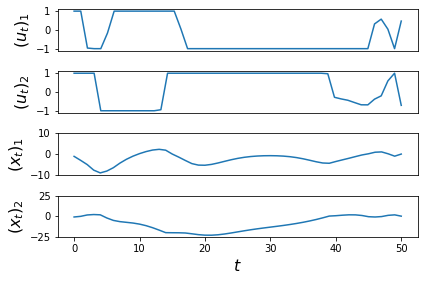

In [10]:
f = plt.figure()

# Plot (u_t)_1.
ax = f.add_subplot(411)
plt.plot(u[0,:].value)
plt.ylabel(r"$(u_t)_1$", fontsize=16)
plt.yticks(np.linspace(-1.0, 1.0, 3))
plt.xticks([])

# Plot (u_t)_2.
plt.subplot(4,1,2)
plt.plot(u[1,:].value)
plt.ylabel(r"$(u_t)_2$", fontsize=16)
plt.yticks(np.linspace(-1, 1, 3))
plt.xticks([])

# Plot (x_t)_1.
plt.subplot(4,1,3)
x1 = x[0,:].value
plt.plot(x1)
plt.ylabel(r"$(x_t)_1$", fontsize=16)
plt.yticks([-10, 0, 10])
plt.ylim([-10, 10])
plt.xticks([])

# Plot (x_t)_2.
plt.subplot(4,1,4)
x2 = x[1,:].value
plt.plot(range(51), x2)
plt.yticks([-25, 0, 25])
plt.ylim([-25, 25])
plt.ylabel(r"$(x_t)_2$", fontsize=16)
plt.xlabel(r"$t$", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Quick start is ok. CVXPY is working

In [8]:
tau = 60 #seconds
time_t = np.arange(0,24,tau/3600)
# time_t = []
N = 24*3600 / tau
# print(N)
N = round(N)
# for i in range(N):
#     time_t.append(i*tau / 3600)
prices_t = price(time_t, type_price='commercial_1')
COP = 3
C_out = 1005 # J/(kg K)
C_in = 1005 # J/(kg K)
m_air = 340 # kg
m_wall = 11520/2 #kg
C_wall = 1500 # J/(kg K)
pa1 = tau/(m_air*C_in)
h = 5 # m
b = 10 # m
k = 0.183 
pa2 = h*b*k
alpha_int = 8.7 # W/ m K
S = 60 # m^2
pa3 = 0.5 * alpha_int * h * (S / b + b)
M_met = 120 # W
# M_met = 80 # TUNED TUNED TUNED TUNED TUNED
T_vent = 21 # ^oC
a_inf = 0.02 / 3600
pa4 = a_inf * m_air * C_out
M_light = 20 # W
N_light = 15
W_light = M_light * N_light
L_evap = 333000 # W/kg
M_moist = 0.000021 # kg/s
pa5 = M_met - L_evap * M_moist
pw1 = tau/(m_wall*C_wall)
pn1 = tau/m_air
pn2 = a_inf * m_air
k_CO2 = 0.038 * 4 # g / s # medium work
ppm_k_CO2 = k_CO2 / 1000 / (S * h) * 1000000 # mass to kg divide by volume and to ppm
T_output = 18 # outer air temperature after TES

N_oc = occup(time_t)
T_out = outtemp_example(time_t, day='B')
prices = price(time_t, type_price='commercial_1')
disch_time = -dischargetime(time_t)

In [34]:
# MINLP -> NILP
P_f = []
for i in range(N):
    if 9 < time_t[i] <= 15.1:
        P_f.append(40)
    else:
        P_f.append(0)

In [35]:
P_f

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [37]:
T = N

P_c = cp.Variable(T, integer = True)
# P_c = cp.Variable(T)

# W_hvac = cp.Variable((1, T))
T_r = cp.Variable(T+1)

T_w = cp.Variable(T+1)
# n_c = cp.Variable(T+1)

cost = 0

# T_room.append(19.8)
# T_wall.append(19)
# n_CO2.append(400)

constr = []

constr += [T_r[0] == 19.8]
constr += [T_w[0] == 19]
# constr += [n_c[0] == 400]

for t in range(T):
    cost += (500*P_c[t] + P_f[t])*prices[t]*tau/3600/1000
    constr += [T_r[t+1] == T_r[t] + pa1 * ((pa2 + pa4)  * (T_out[t] - T_r[t]) + pa3 * (T_w[t] - T_r[t]) + pa5 * N_oc[t] - 500 * P_c[t] * COP +
                             + C_out * T_vent * 0.55 / 100 * P_f[t] - C_in * T_r[t] * 0.55 / 100 * P_f[t] + W_light)]
    
    constr += [T_w[t+1] == T_w[t] + pw1 * pa2 * (T_r[t] - T_w[t])]
    
    constr += [T_r[t+1] >= 18, T_r[t+1] <= 24]
    
    constr += [P_c[t] >= 0, P_c[t] <= 3]
    

In [ ]:
%%time
problem = cp.Problem(cp.Minimize(cost), constr)

# print(problem)
# print("Is this problem DGP?", problem.is_dgp)

# problem.solve(solver=cp.GLPK_MI) # for integer variables
problem.solve(solver=cp.ECOS)

In [27]:
# print(sum(P_c.value)*500 + sum(P_f))
print("Here total cost for MPC MILP = ", cost.value, " rub")
print("In comparison with continuous Non-linear problem objective = 8.13965 rub")
print("Difference is ", (cost.value - 8.13965) / cost.value * 100 , " %")

Here total cost for MPC MILP =  8.165876185681416  rub
In comparison with continuous Non-linear problem objective = 8.13965 rub
Difference is  0.3211680545365486  %


In [ ]:
# Difference is acceptable

In [28]:
P_c[900:920].value*500

array([4.41334619e+02, 3.15745377e+02, 1.90156545e+02, 6.45681175e+01,
       2.02152444e-08, 1.94001646e-08, 1.97094850e-08, 1.98912407e-08,
       1.98683416e-08, 1.97537221e-08, 1.96047948e-08, 1.94492803e-08,
       1.92999613e-08, 1.91621974e-08, 1.90376909e-08, 1.89263829e-08,
       1.88274156e-08, 1.87396196e-08, 1.86617580e-08, 1.85926436e-08])

In [39]:
answer = ''
answer = answer + '['
for i in range(N):
    answer = answer + ' ' + str(round(P_c[0,i].value*500,3)) + ','
answer = answer[:-1] + ']'

In [40]:
with open ('results_CVXPY.txt', 'w') as ouf:
    ouf.write(answer)

In [30]:
print(sum(T_r[:].value > 24)) # check upper boundary

0


In [ ]:
# Solution is sub-optimal

In [33]:
print(sum(P_c[:].value*500+ P_f[:]*1)/3600/1000*tau) # CVXPY total consumption

1.7121689802430125


In [53]:
(176.34634797254307*500+1421.9279817809233*10)/3600/1000*tau # Ipopt total consumption

1.7065408967346793